# NYC Taxi Trip Weather Analysis Notebook

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [3]:
nyc = pd.read_csv('../datasets/nyc_with_features_basic_filtering.csv')
# Path to the zip file
zip_file_path = '../datasets/Weather_Datasets.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open('New_York_City_Weather_in_2016.csv') as weather_file:
        weather_1 = pd.read_csv(weather_file, encoding='latin1')
    with z.open('NYC_Weather_2016_2022_with_wind_clouds.csv') as weather_file:
        weather_2 = pd.read_csv(weather_file, encoding='latin1')

In [4]:
weather_1['Date'] = pd.to_datetime(weather_1['Date'],format="%d/%m/%Y")
weather_2['Date'] = pd.to_datetime(weather_2['time'])
weather_2=weather_2[['Date','cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)','windspeed_10m (km/h)']]
weather = pd.merge(weather_1, weather_2, on='Date', how='inner')

## Weather Dataset

This dataset contains the weather data for New York City in 2016. The dataset contains the following columns:
- Date: The date of the weather data.
- High_Fahrenheit: The high temperature in Fahrenheit.
- Low_Fahrenheit: The low temperature in Fahrenheit.
- Precipitation_inches: The amount of precipitation in inches.
- Snow_inches: The amount of snowfall in inches.

We will use this dataset to add weather data to the NYC Taxi dataset, this might help us understand how the weather affects the trip duration and help us build a better model.

In [5]:
weather.head() 

,Date,Day,Month,Month_num,High_Fahrenheit,Low_Fahrenheit,Precipitation_inches,Snow_inches,cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h)
0,2016-01-01,1,January,1,42,34,0.0,0.0,69.0,53.0,0.0,72.0,10.0
1,2016-01-02,2,January,1,40,32,0.0,0.0,13.0,1.0,20.0,0.0,15.5
2,2016-01-03,3,January,1,45,35,0.0,0.0,5.0,5.0,0.0,0.0,7.2
3,2016-01-04,4,January,1,36,14,0.0,0.0,0.0,0.0,0.0,0.0,10.9
4,2016-01-05,5,January,1,29,11,0.0,0.0,0.0,0.0,0.0,0.0,25.4


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  366 non-null    datetime64[ns]
 1   Day                   366 non-null    int64         
 2   Month                 366 non-null    object        
 3   Month_num             366 non-null    int64         
 4   High_Fahrenheit       366 non-null    int64         
 5   Low_Fahrenheit        366 non-null    int64         
 6   Precipitation_inches  366 non-null    float64       
 7   Snow_inches           366 non-null    float64       
 8   cloudcover (%)        366 non-null    float64       
 9   cloudcover_low (%)    366 non-null    float64       
 10  cloudcover_mid (%)    366 non-null    float64       
 11  cloudcover_high (%)   366 non-null    float64       
 12  windspeed_10m (km/h)  366 non-null    float64       
dtypes: datetime64[ns](1)

In [7]:
# drop some columns that we dont need: Month, Month_num, Day
weather.drop(['Month_num', 'Day', 'Month'], axis=1, inplace=True)

### Exploring the Weather Dataset

Lets start by adding some features to the dataset to help us better understand the data distribution across months and days.

#### Converting to Celsius and Millimeters

In [8]:
# rename High_Fahrenheit, Low_Fahrenheit, Precipitation_inches, Snow_inches to lowercase
weather.rename(columns={'High_Fahrenheit': 'high_fahrenheit', 'Low_Fahrenheit': 'low_fahrenheit', 'Precipitation_inches': 'precipitation_inches', 'Snow_inches': 'snow_inches', 'Date':'date','windspeed_10m (km/h)':'windspeed'}, inplace=True)

# had high_celsius, low_celsius, precipitation_millimeters
weather['high_celsius'] = (weather['high_fahrenheit'] - 32) * 5/9
weather['low_celsius'] = (weather['low_fahrenheit'] - 32) * 5/9
weather['mmPrecipitation'] = weather['precipitation_inches'] * 25.4
weather['mmSnowFall'] = weather['snow_inches'] * 25.4
weather['date'] = pd.to_datetime(weather['date'], format='%d/%m/%Y').dt.date

Remove fahrenheit and inches columns

Keep only single decimal point for all celsius based values.

In [9]:
weather = weather.drop(['low_fahrenheit', 'high_fahrenheit','precipitation_inches', 'snow_inches'], axis=1)
weather['low_celsius'] = weather['low_celsius'].round(1)
weather['high_celsius'] = weather['high_celsius'].round(1)
weather['mmPrecipitation'] = weather['mmPrecipitation'].round(1)
weather['mmSnowFall'] = weather['mmSnowFall'].round(1)


In [10]:
weather.head()

,date,cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed,high_celsius,low_celsius,mmPrecipitation,mmSnowFall
0,2016-01-01,69.0,53.0,0.0,72.0,10.0,5.6,1.1,0.0,0.0
1,2016-01-02,13.0,1.0,20.0,0.0,15.5,4.4,0.0,0.0,0.0
2,2016-01-03,5.0,5.0,0.0,0.0,7.2,7.2,1.7,0.0,0.0
3,2016-01-04,0.0,0.0,0.0,0.0,10.9,2.2,-10.0,0.0,0.0
4,2016-01-05,0.0,0.0,0.0,0.0,25.4,-1.7,-11.7,0.0,0.0


#### Add Classes for Weather Features

In [11]:
import pandas as pd

# Assuming `weather` is your DataFrame containing mmSnowFall, mmPrecipitation, and high_celsius

# Snowfall classification (None, Light, Moderate, Heavy)
# 0.0 mm snowfall is classified as "None"
weather['snowClass'] = pd.cut(weather['mmSnowFall'], 
                               bins=[-0.1, 0.1, 2.5, 50, float('inf')], 
                               labels=['None', 'Light', 'Moderate', 'Heavy'])


# Precipitation classification (None, Light, Moderate, Heavy, Very Heavy)
# 0.0 mm precipitation is classified as "None"
weather['precipitationClass'] = pd.cut(weather['mmPrecipitation'], 
                                        bins=[-1, 0.1, 1, 10, 100], labels=['None', 'Light', 'Moderate', 'Heavy'])

# Temperature classification remains unchanged
weather['tempClass'] = pd.cut(weather['high_celsius'], 
                              bins=[-float('inf'), 0, 10, 20, 30, 40, float('inf')], 
                              labels=['Below 0', '0-10', '10-20', '20-30', '30-40', 'Above 40'])

weather['cloudCoverClass'] = pd.cut(weather['cloudcover (%)'],bins=[-1, 0, 25, 50, 75, 100], labels=['None','Clear','Partly', 'Mostly', 'Overcast'])

weather['windSpeedClass'] = pd.cut(weather['windspeed'], bins=[-1, 0, 12, 25, 37], labels=['None','Calm', 'Breezy', 'Windy'])


In [12]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   date                 366 non-null    object  
 1   cloudcover (%)       366 non-null    float64 
 2   cloudcover_low (%)   366 non-null    float64 
 3   cloudcover_mid (%)   366 non-null    float64 
 4   cloudcover_high (%)  366 non-null    float64 
 5   windspeed            366 non-null    float64 
 6   high_celsius         366 non-null    float64 
 7   low_celsius          366 non-null    float64 
 8   mmPrecipitation      366 non-null    float64 
 9   mmSnowFall           366 non-null    float64 
 10  snowClass            366 non-null    category
 11  precipitationClass   366 non-null    category
 12  tempClass            366 non-null    category
 13  cloudCoverClass      366 non-null    category
 14  windSpeedClass       366 non-null    category
dtypes: category(5), float64

#### Merge the Weather Data with the NYC Taxi Dataset and OSRM Dataset

In [13]:
nyc['pickup_date'] = pd.to_datetime(nyc['pickup_datetime']).dt.date

nyc = nyc.merge(weather, left_on='pickup_date', right_on='date')

In [14]:
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,windspeed,high_celsius,low_celsius,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm


In [15]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458575 entries, 0 to 1458574
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   id                       1458575 non-null  object  
 1   vendor_id                1458575 non-null  int64   
 2   pickup_datetime          1458575 non-null  object  
 3   dropoff_datetime         1458575 non-null  object  
 4   passenger_count          1458575 non-null  int64   
 5   pickup_longitude         1458575 non-null  float64 
 6   pickup_latitude          1458575 non-null  float64 
 7   dropoff_longitude        1458575 non-null  float64 
 8   dropoff_latitude         1458575 non-null  float64 
 9   store_and_fwd_flag       1458575 non-null  bool    
 10  trip_duration            1458575 non-null  int64   
 11  pickup_day_of_week       1458575 non-null  object  
 12  dropoff_day_of_week      1458575 non-null  object  
 13  month                    14

In [16]:
# get only rows from weather that are in nyc
weather = weather[weather['date'].isin(nyc['pickup_date'])]

#### Temperature class distribution

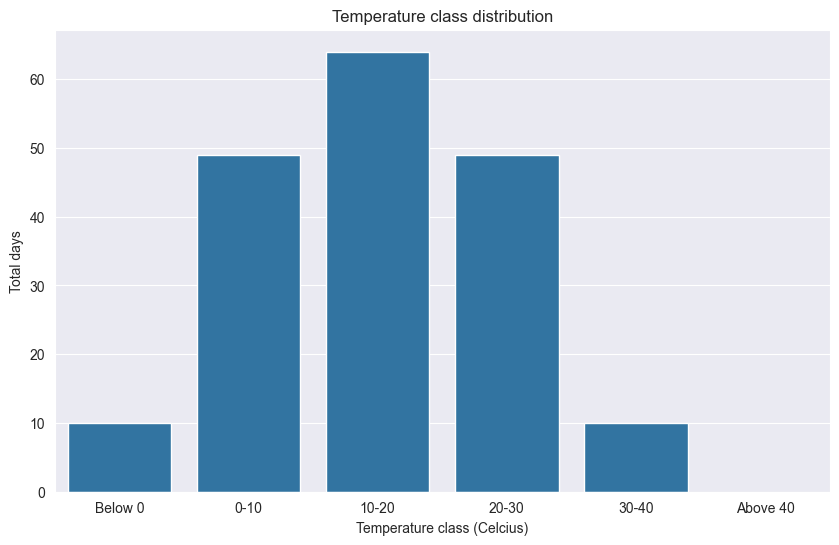

In [17]:
# plot the distribution of the temperature classes
plt.figure(figsize=(10, 6))
sns.countplot(x='tempClass', data=weather, order=['Below 0', '0-10', '10-20', '20-30', '30-40', 'Above 40'])
plt.title('Temperature class distribution')
plt.xlabel('Temperature class (Celcius)')
plt.ylabel('Total days')
plt.show()

Insights: The temperature class distribution shows that most days in New York City have temperatures between 10-30 degrees Celsius, with fewer days having temperatures below 0 or above 30 degrees Celsius.

#### Wind distribution

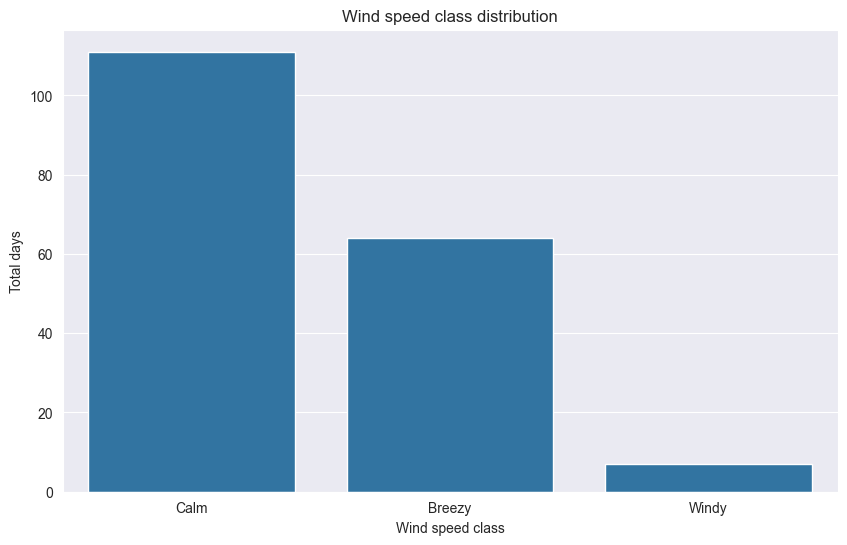

In [18]:
# plot the distribution of the wind classes
plt.figure(figsize=(10, 6))
sns.countplot(x='windSpeedClass', data=weather, order=['Calm', 'Breezy', 'Windy'])
plt.title('Wind speed class distribution')
plt.xlabel('Wind speed class')
plt.ylabel('Total days')
plt.show()

Insights: The wind speed class distribution shows that most days in New York City have calm winds, with fewer days having breezy or windy conditions.

#### Cloud cover days distribution

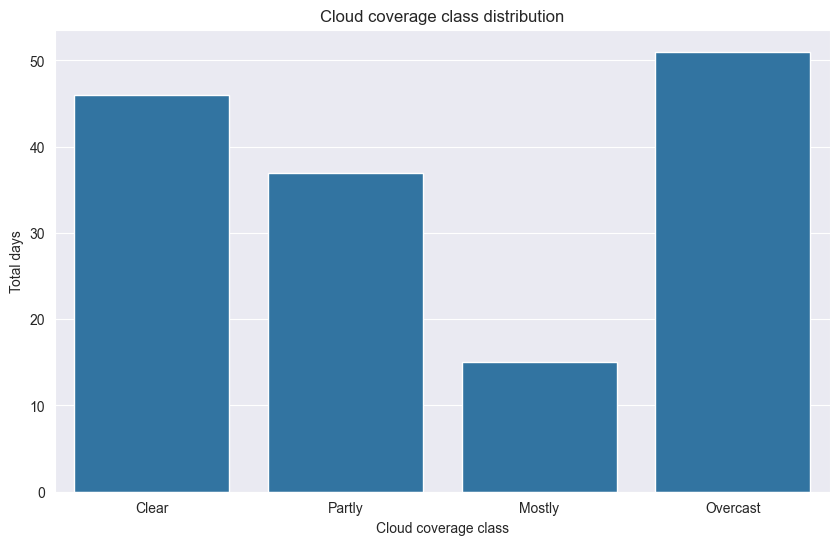

In [19]:
# plot the distribution of the wind classes
plt.figure(figsize=(10, 6))
sns.countplot(x='cloudCoverClass', data=weather, order=['Clear', 'Partly', 'Mostly','Overcast'])
plt.title('Cloud coverage class distribution')
plt.xlabel('Cloud coverage class')
plt.ylabel('Total days')
plt.show()

Insights: Looks like new york is very cloudy.

#### Snowy days distribution

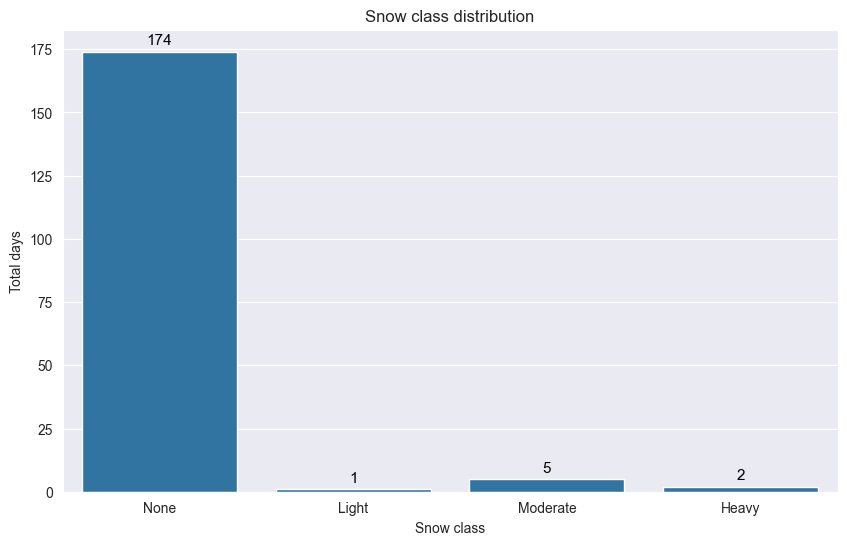

In [20]:
# plot the distribution of the snow classes
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='snowClass', data=weather, order=['None', 'Light', 'Moderate', 'Heavy'])
plt.title('Snow class distribution')
plt.xlabel('Snow class')
plt.ylabel('Total days')

# Annotate the bars with the counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

Insights: Only few days have snowfall in new york.

#### Precipitation class distribution

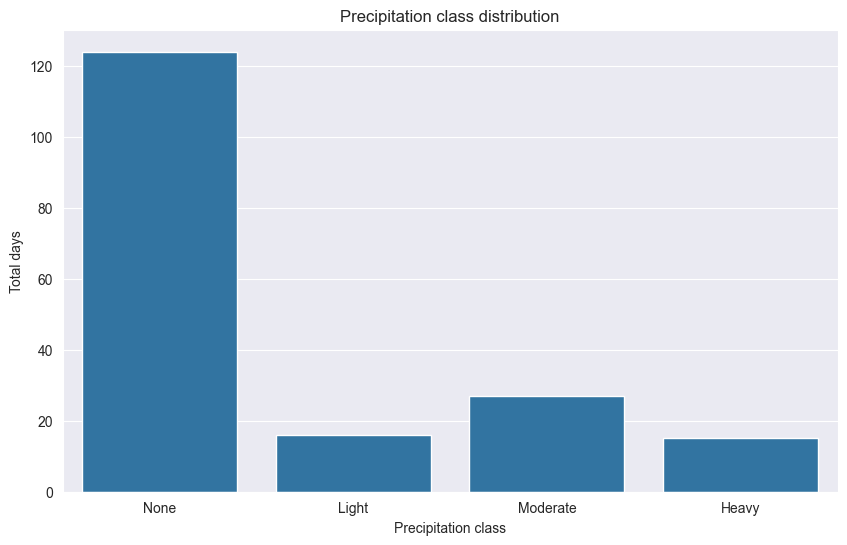

In [21]:
# plot the distribution of the precipitation classes
plt.figure(figsize=(10, 6))
sns.countplot(x='precipitationClass', data=weather, order=['None', 'Light', 'Moderate', 'Heavy'])

plt.title('Precipitation class distribution')
plt.xlabel('Precipitation class')
plt.ylabel('Total days')
plt.show()

Insights: Most days in New York City have no precipitation, with fewer days having light to heavy precipitation.

Convert times to datetime

In [22]:
nyc['pickup_datetime']=pd.to_datetime(nyc['pickup_datetime'])
nyc['dropoff_datetime']=pd.to_datetime(nyc['dropoff_datetime'])

Add day of year column

In [23]:
nyc['day_of_year'] = nyc['pickup_datetime'].dt.dayofyear

In [24]:
# merge the two dataframes
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,windspeed,high_celsius,low_celsius,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,False,...,7.6,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm


In [25]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458575 entries, 0 to 1458574
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1458575 non-null  object        
 1   vendor_id                1458575 non-null  int64         
 2   pickup_datetime          1458575 non-null  datetime64[ns]
 3   dropoff_datetime         1458575 non-null  datetime64[ns]
 4   passenger_count          1458575 non-null  int64         
 5   pickup_longitude         1458575 non-null  float64       
 6   pickup_latitude          1458575 non-null  float64       
 7   dropoff_longitude        1458575 non-null  float64       
 8   dropoff_latitude         1458575 non-null  float64       
 9   store_and_fwd_flag       1458575 non-null  bool          
 10  trip_duration            1458575 non-null  int64         
 11  pickup_day_of_week       1458575 non-null  object        
 12  

#### Temperature Variation

We will use the daily high and low temperatures to calculate the temperature at a given hour based on a sinusoidal function.

In [26]:
def temperature_variation(hour, daily_high, daily_low):
    """
    Calculate the temperature at a given hour based on daily high and low temperatures.

    Parameters:
    hour (int): The hour of the day (0-23).
    daily_high (float): The daily high temperature.
    daily_low (float): The daily low temperature.

    Returns:
    float: The temperature at the given hour.
    """
    # Calculate the average temperature
    avg_temp = (daily_high + daily_low) / 2
    
    # Calculate the amplitude of the temperature variation
    amplitude = (daily_high - daily_low) / 2
    
    # Calculate the temperature at the given hour using a sinusoidal function
    temperature = avg_temp + amplitude * np.sin((np.pi / 12) * (hour - 6))
    
    return temperature

nyc['pickup_temp_celsius'] = nyc.apply(lambda x: temperature_variation(x['pickup_hour'], x['high_celsius'], x['low_celsius']), axis=1)
nyc['pickup_temp_celsius'] = nyc['pickup_temp_celsius'].round(1)

In [27]:
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,high_celsius,low_celsius,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass,pickup_temp_celsius
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm,8.3
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,False,...,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm,10.2
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,False,...,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm,9.7
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,False,...,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm,6.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,False,...,10.6,4.4,7.4,0.0,None,Moderate,10-20,Overcast,Calm,10.2


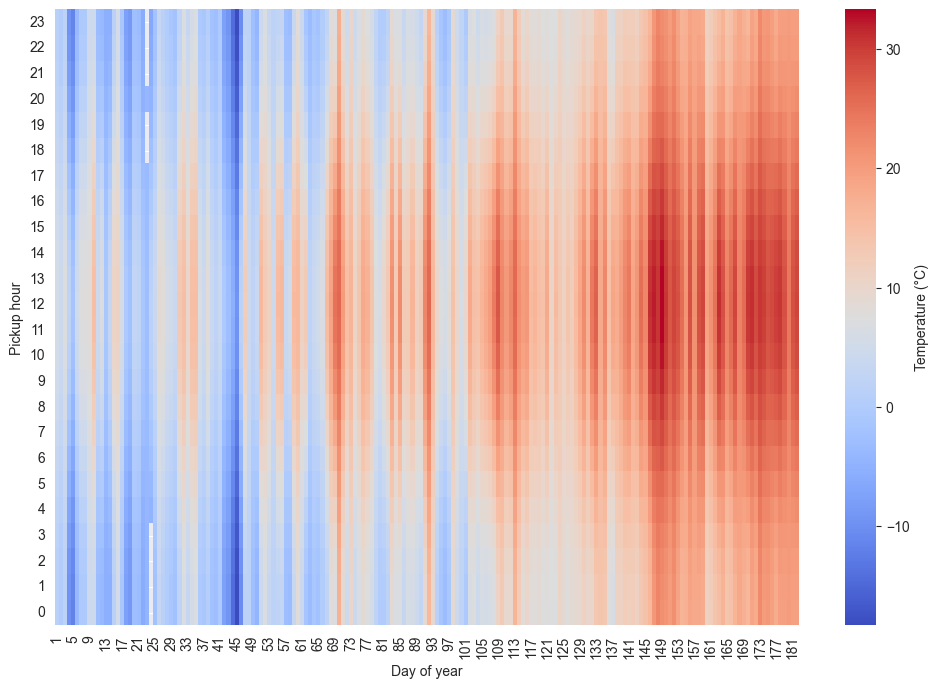

In [28]:
# Aggregate the data by taking the mean temperature for each combination of pickup_hour and day_of_year
aggregated_data = nyc.groupby(['pickup_hour', 'day_of_year']).pickup_temp_celsius.mean().reset_index()

# Pivot the DataFrame to get the format suitable for heatmap
heatmap_data = aggregated_data.pivot(index="pickup_hour", columns="day_of_year", values="pickup_temp_celsius")

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={'label': 'Temperature (°C)'})
plt.yticks(rotation=0)
plt.xlabel('Day of year')
plt.ylabel('Pickup hour')
plt.gca().invert_yaxis()
plt.show()

Insights: The heatmap shows the variation in temperature throughout the year for different hours of the day. The temperature is generally higher during the day and lower during the night, with seasonal variations. The temperature variation is more pronounced in the winter months compared to the summer months.

In [29]:
# add low_celsius to high_celsius difference
nyc['max_temp_diff'] = nyc['high_celsius'] - nyc['low_celsius']

In [72]:
# save the data
nyc.to_csv('nyc_with_weather_and_osrm_clean.csv', index=False)

In [73]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406685 entries, 0 to 1406684
Data columns (total 57 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1406685 non-null  object        
 1   vendor_id                1406685 non-null  int64         
 2   pickup_datetime          1406685 non-null  datetime64[ns]
 3   dropoff_datetime         1406685 non-null  datetime64[ns]
 4   passenger_count          1406685 non-null  int64         
 5   pickup_longitude         1406685 non-null  float64       
 6   pickup_latitude          1406685 non-null  float64       
 7   dropoff_longitude        1406685 non-null  float64       
 8   dropoff_latitude         1406685 non-null  float64       
 9   store_and_fwd_flag       1406685 non-null  bool          
 10  trip_duration            1406685 non-null  int64         
 11  pickup_day_of_week       1406685 non-null  object        
 12  